In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

### Reweighting

An example of the training data, consisting of $N$ hadronization events (in the dataset below $N = 100,000$), is:
$$
\boldsymbol{z} = 
  \begin{pmatrix}
    \boldsymbol{z}_1 = 
    \begin{pmatrix} 
        \big\{ z^{h_1}_{\text{accept}}, z^{1, h_1}_{\text{reject}}, z^{2, h_1}_{\text{reject}}, \cdots, 									  z^{n_{h_1}, h_1}_{\text{reject}}\big\} \\
        \big\{ z^{h_2}_{\text{accept}}, z^{1, h_2}_{\text{reject}}, z^{2, h_2}_{\text{reject}}, \cdots, z^{n_{h_2}, h_2}_{\text{reject}} \big\} \\	
        \big\{ z^{h_3}_{\text{accept}}, z^{1, h_3}_{\text{reject}}, z^{2, h_3}_{\text{reject}}, \cdots, z^{n_{h_3}, h_3}_{\text{reject}} \big\} 
        \end{pmatrix}_1 \\
    \boldsymbol{z}_2 = 
    \begin{pmatrix} 
      \big\{ z^{h_1}_{\text{accept}}, z^{1, h_1}_{\text{reject}}, z^{2, h_1}_{\text{reject}}, \cdots, z^{n_{h_1}, h_1}_{\text{reject}}\big\} \\
      \vdots \\	
      \big\{ z^{h_4}_{\text{accept}}, z^{1, h_4}_{\text{reject}}, z^{2, h_4}_{\text{reject}}, \cdots, z^{n_{h_4}, h_4}_{\text{reject}} \big\} 
      \end{pmatrix}_2 \\
      \vdots \\
    \boldsymbol{z}_N = \cdots
  \end{pmatrix},
$$
$$
\boldsymbol{y}_\text{sim} = 
  \begin{pmatrix}
    \boldsymbol{y}_1 = N_{h,1} = 3\\
    \boldsymbol{y}_2 = N_{h,2} = 4 \\
    \vdots \\
    \boldsymbol{y}_N = N_{h,N} = 2
\end{pmatrix}
$$
Note that each array $\boldsymbol{z}_i$ is zero-padded to a fixed length of size $50$ and each accept-reject array is zero-padded to a fixed length of size $100$ (the maximum number of rejections is 99).

In [3]:
# Load the accept-reject data
#filename_accept_reject_monash = './pgun_qqbar_accept_reject_z_a_0.68_b_0.98_sigma_0.335_N_1e6.npy'
#pgun_accept_reject_monash = np.load(filename_accept_reject_monash, mmap_mode = "r")

filename_accept_reject_monash_prime = './pgun_qqbar_finalTwo_accept_reject_z_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'
pgun_accept_reject_monash_prime = np.load(filename_accept_reject_monash_prime, mmap_mode = "r")

# Load fPrel data
filename_fPrel_monash_prime = './pgun_qqbar_finalTwo_fPrel_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'
pgun_fPrel_monash_prime = np.load(filename_fPrel_monash_prime, mmap_mode = "r")

# Load the hadron data
filename_hadrons_monash = './pgun_qqbar_finalTwo_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e5.npy'
pgun_hadrons_monash = np.load(filename_hadrons_monash, mmap_mode="r")

filename_hadrons_monash_prime = './pgun_qqbar_finalTwo_hadrons_a_0.72_b_0.88_sigma_0.335_N_1e5.npy'
pgun_hadrons_monash_prime = np.load(filename_hadrons_monash_prime, mmap_mode="r")

In [4]:
#print("Accepted and rejected z data shape (Monash):", pgun_accept_reject_monash.shape)
print("Hadron data shape (Monash):", pgun_hadrons_monash.shape)

print("Accepted and rejected z data shape (Monash'):", pgun_accept_reject_monash_prime.shape)
print("fPrel data shape (Monash'):", pgun_fPrel_monash_prime.shape)
print("Hadron data shape (Monash'):", pgun_hadrons_monash_prime.shape)

Hadron data shape (Monash): (100000, 75, 5)
Accepted and rejected z data shape (Monash'): (50000, 105, 101)
fPrel data shape (Monash'): (50000, 105, 100)
Hadron data shape (Monash'): (100000, 75, 5)


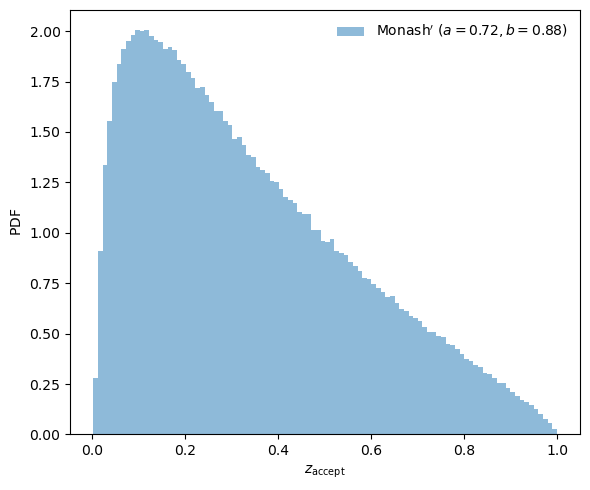

In [4]:
# Histrogram accepted z-values across all events
fig, ax = plt.subplots(1,1,figsize=(6,5))
#ax.hist(pgun_accept_reject_monash[:,:,0][pgun_accept_reject_monash[:,:,0] > 0.0], 100, alpha = 0.5, density = True, label = r'$\mathrm{Monash}$ $(a = 0.68, b = 0.98)$')
ax.hist(pgun_accept_reject_monash_prime[:,:,1][pgun_accept_reject_monash_prime[:,:,1] > 0.0], 100, alpha = 0.5, density = True, label = r"$\mathrm{Monash'}$ $(a = 0.72, b = 0.88)$")
ax.set_xlabel(r'$z_{\mathrm{accept}}$')
ax.set_ylabel(r'$\mathrm{PDF}$')
ax.legend(frameon = False)
fig.tight_layout()

In [5]:
# Collect multiplicity data
mult_monash = np.array([len(pgun_hadrons_monash[i,:][np.abs(pgun_hadrons_monash[i,:,0]) > 0.0]) for i in range(pgun_hadrons_monash.shape[0])])
#mult_island = np.array([len(pgun_hadrons_island[i,:][pgun_hadrons_island[i,:,0] > 0.0]) for i in range(pgun_hadrons_island.shape[0])])
mult_monash_prime = np.array([len(pgun_hadrons_monash_prime[i,:][np.abs(pgun_hadrons_monash_prime[i,:,0]) > 0.0]) for i in range(pgun_hadrons_monash_prime.shape[0])])

In [6]:
print(mult_monash.shape)
print(mult_monash_prime.shape)


(100000,)
(100000,)


2.0 30.0
1.0 32.0


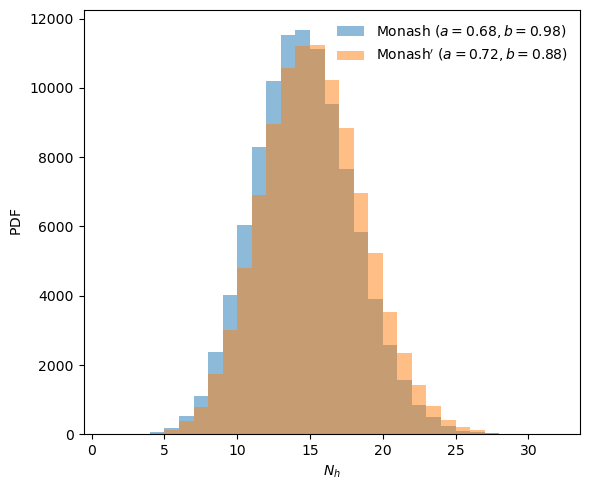

In [7]:
# Histrogram hadron multiplicity
fig, ax = plt.subplots(1,1,figsize=(6,5))

_, bins_monash = np.histogram(mult_monash)
_, bins_monash_prime = np.histogram(mult_monash_prime)

min_monash, max_monash = bins_monash[0], bins_monash[-1]
min_monash_prime, max_monash_prime = bins_monash_prime[0], bins_monash_prime[-1]
print(min_monash, max_monash)
print(min_monash_prime, max_monash_prime)

min = np.min([min_monash, min_monash_prime])
max = np.max([max_monash, max_monash_prime])

bins = np.linspace(min, max, int((max - min)+1))

counts, _, _ = ax.hist(mult_monash, bins, alpha = 0.5, density = False, label = r'$\mathrm{Monash}$ $(a = 0.68, b = 0.98)$')
ax.hist(mult_monash_prime, bins = bins, alpha = 0.5, density = False, label = r"$\mathrm{Monash'}$ $(a = 0.72, b = 0.88)$")
#ax.hist(mult_island, bins = bins, alpha = 0.5, density = True, label = r"$\mathrm{'Island'}$ $(a = 1.5, b = 0.6)$")
ax.set_xlabel(r'$N_h$')
ax.set_ylabel(r'$\mathrm{PDF}$')
ax.legend(frameon = False)
fig.tight_layout()

In [8]:
print('Bins:', bins)
print('Counts:', counts)
print(bins.shape)
print(counts.shape)


Bins: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.]
Counts: [0.0000e+00 1.0000e+00 2.1000e+01 5.5000e+01 1.8700e+02 5.2000e+02
 1.0980e+03 2.3790e+03 4.0350e+03 6.0410e+03 8.2990e+03 1.0208e+04
 1.1518e+04 1.1666e+04 1.1128e+04 9.5410e+03 7.6480e+03 5.8300e+03
 3.9160e+03 2.5760e+03 1.5540e+03 8.4600e+02 4.9200e+02 2.4800e+02
 9.8000e+01 5.5000e+01 2.4000e+01 1.0000e+01 4.0000e+00 2.0000e+00
 0.0000e+00]
(32,)
(31,)


The reweighting module computes a weight array, given the base $B$ and perturbed $P$ parameterizations, according to 
$$
\boldsymbol{w} = \begin{pmatrix}
    w_1 \\
    w_2 \\
    \vdots \\
    w_N
  \end{pmatrix}, \text{ where } \\
  w_n = \prod_{i = 1}^{N_{h,n}} \left(\frac{f(z^{h_i}_\text{accept}; \{a, b\}_P)}{f(z^{h_i}_\text{accept}; \{a, b\}_{B})}\right)
  \prod_{j = 1}^{n_{h_i}} \left(\frac{\hat{f} - f(z^{j, h_i}_\text{reject}; \{a, b\}_P)}{\hat{f} - f(z^{j, h_i}_\text{reject}; \{a, b\}_{B}}\right)
$$
where $\hat{f}$ is the oversampling factor associated with the sampling of $z$ (here the over-sampling factor is 10). For each event, the accepcted and rejected $z$-values as well as the transverse mass $m_T^2 = p_x^2 + p_y^2 + m^2$ of each hadron is required to compute the event weight.

In [16]:
# The finalTwo reweighting module
class LundWeight(nn.Module):
    def __init__(self, params_base, params, over_sample_factor):
        super(LundWeight, self).__init__()
        self.params_base = params_base
        self.params_a = torch.nn.Parameter(params[0].clone(), requires_grad=True)
        self.params_b = torch.nn.Parameter(params[1].clone(), requires_grad=True)
        self.over_sample_factor = over_sample_factor

        self.AFROMZERO = 0.02
        self.EXPMAX = 50.
        self.AFROMC = 0.01
        self.CFROMUNITY = 0.01
    
    def zMaxCalc(self, a, b, c):
        # Normalization for Lund fragmentation function so that f <= 1.
        # Special cases for a = 0 and a = c.
        aIsZero = (a < self.AFROMZERO)
        aIsC = (torch.abs(a - c) < self.AFROMC)
        # Determine position of maximum.
        if aIsZero:
            return b / c if c > b else 1.
        elif aIsC:
            return b / (b + c)
        else:
            zMax = 0.5 * (b + c - torch.sqrt(torch.pow(b - c, 2) + 4 * a * b)) / (c - a)
            if torch.isnan(zMax).any():
                print('zMax_1', zMax)
                print('a', a, 'b', b, 'c', c)
                exit()
            # Grab indicies for special condition
            # Assuming zMax, a, and b are PyTorch tensors of the same shape
            zMax = torch.where((zMax > 0.9999) & (b > 100.), torch.min(zMax, 1. - a / b), zMax)
            return zMax
    """
    def fPrelCalc(self, z, mT, a, b, c=torch.tensor(1., requires_grad=True)):
        
        #Calculates the value of the 'fPrel' variable based on the input parameters.

        #Args:
            z (torch.Tensor): The current value of z.
            zMax (float): Maximum value of the distribution.
            b (float): Parameter controlling the shape of the distribution.
            c (float): Parameter controlling the shape of the distribution.
            cIsUnity (bool): Indicates whether c is unity.
            zDiv (float): The value of zDiv.
            zDivC (float): The value of zDivC.

        Returns:
            torch.Tensor: The calculated value of fPrel.
        
        cIsUnity = torch.abs(c - 1.) < self.CFROMUNITY
        aIsZero = (a < self.AFROMZERO)
        print('aIsZero', aIsZero)
        # Adjust b-parameter
        b = b * mT
        # Compute zMax
        zMax = self.zMaxCalc(a, b, c=torch.tensor(1., requires_grad=True))
        #print(zMax)

        peakedNearZero = (zMax < 0.1)
        peakedNearUnity = (zMax > 0.85) & (b > 1.)
    
        # Initialize zDiv
        zDiv = torch.ones_like(zMax)
        
        zDiv = torch.where(peakedNearZero, 2.75 * zMax, zDiv)
        rcb = torch.sqrt(4. + torch.pow(c / b, 2))
        zDiv = torch.where(peakedNearUnity, rcb - (1. / zMax) - (c / b) * torch.log(zMax * 0.5 * (rcb + c / b)), zDiv)
        if ~aIsZero:
            zDiv = torch.where(peakedNearUnity, zDiv + (a / b) * torch.log(1. - zMax), zDiv)
        zDiv = torch.min(zMax, torch.max(torch.tensor(0.), zDiv))

        fPrel = torch.ones_like(zMax)
        fPrel = torch.where(peakedNearZero, torch.pow(zDiv / z, c), torch.where() fPrel)

        # Handle the case where peakedNearZero is True
        #zDiv_peakedZero = 2.75 * zMax
#
        ## Handle the case where peakedNearUnity is True
        #rcb = torch.sqrt(4. + torch.pow(c / b, 2))
        #zDiv_peakedUnity = rcb - 1. / zMax - (c / b) * torch.log(zMax * 0.5 * (rcb + c / b))
        #zDiv_peakedUnity = torch.where(
        #    ~aIsZero,
        #    zDiv_peakedUnity + (a / b) * torch.log(1. - zMax),
        #    zDiv_peakedUnity
        #)
        #zDiv_peakedUnity = torch.min(zMax, torch.max(torch.tensor(0.), zDiv_peakedUnity))
#
        ## Combine zDiv using the conditions
        #zDiv = torch.where(peakedNearZero, zDiv_peakedZero, zDiv)
        #zDiv = torch.where(peakedNearUnity, zDiv_peakedUnity, zDiv)
#
        ## Initialize fPrel
        #fPrel = torch.ones_like(zMax)
#
        ## Compute fPrel based on the conditions
        #if peakedNearZero.any():
        #    fPrel = torch.where(
        #        z < zDiv,
        #        fPrel,  # fPrel remains 1 when z < zDiv
        #        torch.where(
        #            cIsUnity,
        #            zDiv / z,
        #            torch.pow(zDiv / z, c)
        #        )
        #    )
    #
        #if peakedNearUnity.any():
        #    fPrel = torch.where(
        #        z < zDiv,
        #        torch.exp(b * (z - zDiv)),
        #        fPrel  # fPrel remains 1 when z > zDiv
        #    )
        
        peakedNearZero = (zMax < 0.1)
        peakedNearUnity = (zMax > 0.85 and b > 1.)

        # Calculate zDiv and zDivC
        if peakedNearZero:
            zDiv = 2.75 * zMax
        elif peakedNearUnity:
            rcb = torch.sqrt(4. + torch.pow(c / b, 2))
            zDiv = rcb - (1. / zMax) - (c / b) * torch.log(zMax * 0.5 * (rcb + c / b))
            if not torch.isclose(a, torch.tensor(0.)):
                zDiv += (a / b) * torch.log(1. - zMax)
            zDiv = torch.min(zMax, torch.max(torch.tensor(0.), zDiv))
        else:
            zDiv = torch.tensor(0.5)

            fPrel = torch.tensor(1.)

        if peakedNearZero:
            if cIsUnity:
                fPrel = zDiv / z
            else:
                fPrel = torch.pow(zDiv / z, c)
        elif peakedNearUnity:
            fPrel = torch.exp(b * (z - zDiv))
        
        return fPrel
    """
    def likelihood(self, z, mT, a, b, c=torch.tensor(1., requires_grad=True), z_mask=None, mT_mask=None, fPrel_mask=None):
        """
        Compute the likelihood of the Lund fragmentation function, with separate masks for z and mT,
        and handling different shapes for z and mT

        Args:
            z (torch.Tensor): Input tensor
            mT (torch.Tensor): Transverse mass tensor (can be different shape from z)
            a (torch.Tensor): Parameter a
            b (torch.Tensor): Parameter b
            c (torch.Tensor): Parameter c (default: torch.tensor(1., requires_grad=True))
            z_mask (torch.Tensor, optional): Boolean mask tensor for z (default: None)
            mT_mask (torch.Tensor, optional): Boolean mask tensor for mT (default: None)

        Returns:
            torch.Tensor: Computed likelihood values (shape determined by broadcasting rules)
        """

        # Determine the shape after broadcasting
        broadcast_shape = torch.broadcast_shapes(z.shape, mT.shape)

        # If no masks are provided, consider all elements
        if z_mask is None:
            z_mask = torch.ones(z.shape, dtype=torch.bool, device=z.device)
        if mT_mask is None:
            mT_mask = torch.ones(mT.shape, dtype=torch.bool, device=mT.device)

        # Broadcast z, mT, and their masks to the common shape
        z_broad = z.expand(broadcast_shape)
        mT_broad = mT.expand(broadcast_shape)
        z_mask_broad = z_mask.expand(broadcast_shape)
        mT_mask_broad = mT_mask.expand(broadcast_shape)
    
        # Combine masks
        combined_mask = z_mask_broad & mT_mask_broad
        
        # Create a tensor to store the results, initialized with zeros
        likelihood = torch.zeros(broadcast_shape, dtype=z.dtype, device=z.device)
    
        # Only perform calculations on unmasked elements
        z_unmasked = z_broad[combined_mask]
        mT_unmasked = mT_broad[combined_mask]
    
        # Check if we have any unmasked elements to process
        if z_unmasked.numel() > 0:
            # Adjust b-parameter
            b_exp = b * mT_unmasked
            
            # Special case for a = 0.
            aIsZero = (a < self.AFROMZERO)
            cIsUnity = torch.abs(c - 1.) < self.CFROMUNITY
            
            # Determine position of maximum.
            zMax = self.zMaxCalc(a, b_exp, c)
            
            # Be careful of -inf values in aCoeff, very nasty bug to find.
            aCoef = torch.log(1. - z_unmasked) - torch.log(1. - zMax)
            if torch.isneginf(aCoef).any():
                print('aCoef is returning -inf value, please check that all z < 1.')
                print('aCoeff', aCoef)
    
            bCoef = (1. / zMax) - (1. / z_unmasked)
            cCoef = torch.log(zMax) - torch.log(z_unmasked)
            fExp = b_exp * bCoef + c * cCoef
            
            # Special cases for a = 0.
            if ~aIsZero:
                fExp = fExp + a * aCoef
            #fExp = torch.where(aIsZero, fExp, fExp + a * aCoef)
            
            fVal = torch.exp(torch.clamp(fExp, min=-self.EXPMAX, max=self.EXPMAX))
            
            # Assign computed values back to the result tensor
            likelihood[combined_mask] = fVal
        
        return likelihood

    def forward(self, z, fPrel):
        """
        Forward pass of the weight module -- consists of computing the event weights for a given batch
        of training data.
        """
        batch_size = z.shape[0]
        weights = torch.ones(batch_size)

        # The real optimization will be converting the accept-reject arrays into column vectors
        # I will need to include an additional condition with the likelihood computation to account 
        # for the zero-padding and for the fact that the accepted and rejected values will need
        # different values from the likelihood in order to ensure unit weights.

        # Let's do it
        
        # First extract the mT2 values 
        mT2 = z[:, :, 0]
        # Reshape into column tensor
        mT2 = mT2.view(mT2.shape[0], mT2.shape[1], 1)
        # Create a mask for zero values
        mT2_mask = mT2 != 0.

        # Extract the accepted z values
        z_accept = z[:, :, 1]
        # Reshape into column tensor
        z_accept = z_accept.view(z_accept.shape[0], z_accept.shape[1], 1)
        # Remove any zero values
        z_accept_mask = z_accept != 0.

        # First extract the rejected z values
        z_reject = z[:, :, 2:]
        # Reshape into column tensor
        z_reject = z_reject.view(z_reject.shape[0], z_reject.shape[1], z_reject.shape[2])
        # Remove any zero values along the event index
        z_reject_mask = z_reject != 0.

        # I actually don't need fPrel for the accepted z-values
        #fPrel_accept = fPrel[:, :, 0]
        #fPrel_accept = fPrel_accept.view(fPrel_accept.shape[0], fPrel_accept.shape[1], 1)
        #fPrel_accept_mask = fPrel_accept != 0.

        fPrel_reject = fPrel[:, :, 1:]
        fPrel_reject = fPrel_reject.view(fPrel_reject.shape[0], fPrel_reject.shape[1], fPrel_reject.shape[2])
        fPrel_reject_mask = fPrel_reject != 0.

        #print('z:', z_accept)
        #print('accept likelihood', self.likelihood(z_accept, mT2, self.params_base[0], self.params_base[1], z_mask=z_accept_mask, mT_mask=mT2_mask))

        #print('z:', z_reject)
        #print('reject likelihood', self.likelihood(z_reject, mT2, self.params_base[0], self.params_base[1], z_mask=z_reject_mask, mT_mask=mT2_mask))
        #accept_likelihood_pert, _  = self.likelihood(z_accept, mT2, self.params_a, self.params_b, z_mask=z_accept_mask, mT_mask=mT2_mask)
        #print('accept likelihood new', accept_likelihood_new)
        #accept_likelihood_base, _ = self.likelihood(z_accept, mT2, self.params_base[0], self.params_base[1], z_mask=z_accept_mask, mT_mask=mT2_mask)
        #print('accept likelihood base', accept_likelihood_base)
        #reject_likelihood_pert, fPrel_pert  = self.likelihood(z_reject, mT2.expand_as(z_reject), self.params_a, self.params_b, z_mask=z_reject_mask, mT_mask=mT2_mask.expand_as(z_reject))
        #reject_likelihood_base, fPrel_base = self.likelihood(z_reject, mT2.expand_as(z_reject), self.params_base[0], self.params_base[1], z_mask=z_reject_mask, mT_mask=mT2_mask.expand_as(z_reject))
        
        # Compute weights
        #accept_weights = accept_likelihood_pert / accept_likelihood_base
        #print(accept_weights)
        #reject_weights = ((self.over_sample_factor * ) - reject_likelihood_pert) / (self.over_sample_factor - reject_likelihood_base)
        #print('fPrel', self.fPrelCalc(z_reject, mT2, self.params_base[0], self.params_base[1]))

        accept_weights = self.likelihood(z_accept, mT2, self.params_a, self.params_b, z_mask = z_accept_mask, mT_mask = mT2_mask) / self.likelihood(z_accept, mT2, self.params_base[0], self.params_base[1], z_mask = z_accept_mask, mT_mask = mT2_mask)    
        reject_weights = ((self.over_sample_factor * (fPrel_reject * fPrel_reject_mask.masked_fill(z_accept_mask == 0, 1))) - self.likelihood(z_reject, mT2, self.params_a, self.params_b, z_mask = z_reject_mask, mT_mask = mT2_mask)) / ((self.over_sample_factor * (fPrel_reject * fPrel_reject_mask.masked_fill(z_accept_mask == 0, 1))) - self.likelihood(z_reject, mT2, self.params_base[0], self.params_base[1], z_mask = z_reject_mask, mT_mask = mT2_mask))

        #print('accept weights shape', accept_weights.shape)
        #print('reject weights shape', reject_weights.shape)
        #print('accept weights', accept_weights[0])
        #print('reject weights', reject_weights[0])

        #print(accept_weights.masked_select(z_accept_mask))

        #accept_weights = torch.prod(accept_weights.masked_select(z_accept_mask).reshape(mT2.shape[0], -1), dim=1, keepdim=True)
        #print(accept_weights)
        #print(accept_weights * z_accept_mask)
        accept_weights = (accept_weights * z_accept_mask).masked_fill(z_accept_mask == 0, 1).prod(dim=2).prod(dim=1)
        #print('accept weights', accept_weights)
        #print(accept_weights.shape)

        reject_weights = (reject_weights * z_reject_mask).masked_fill(z_reject_mask == 0, 1).prod(dim=2).prod(dim=1)
        #print('reject weights', reject_weights)
        #print(reject_weights.shape)
            
        # Compute event weight
        weights = accept_weights * reject_weights
        #weights[i] = event_weight
    
        return weights

In [17]:
# Set base parameterization 
params_base = torch.tensor([0.72, 0.88]) # Monash' (a,b)

# Set parameters to rewieigh to (data)
params_target = torch.tensor([0.68, 0.98]) # Monash (a,b)

# Set the over sample factor (for the pgun_qqbar datasets this is 10.)
over_sample_factor = 10.

# Initialize the reweighting module
reweighter = LundWeight(params_base, params_target, over_sample_factor = over_sample_factor)

In [30]:
# Consider a 'batch' consisting of 50,000 events
nevents = 25000
# Convert the numpy arrays to torch tensors
#pgun_accept_reject_monash_torch = torch.from_numpy(pgun_accept_reject_monash[0:nevents].copy())
#pgun_mT_monash_torch = torch.from_numpy(pgun_mT_monash[0:nevents].copy())
#pgun_mult_monash_torch = torch.from_numpy(mult_monash[0:nevents].copy())
#pgun_mult_monash_torch = torch.reshape(pgun_mult_monash_torch, (nevents,1))

pgun_accept_reject_monash_prime_torch = torch.from_numpy(pgun_accept_reject_monash_prime[0:nevents].copy())
pgun_fPrel_monash_prime_torch = torch.from_numpy(pgun_fPrel_monash_prime[0:nevents].copy())
# Check for values of 1 and correct
epsilon = 1e-10
pgun_accept_reject_monash_prime_torch[pgun_accept_reject_monash_prime_torch == 1] -= epsilon
pgun_mult_monash_prime_torch = torch.from_numpy(mult_monash_prime[0:nevents].copy())
pgun_mult_monash_prime_torch = torch.reshape(pgun_mult_monash_prime_torch, (nevents,1))

In [31]:
# Check the shapes
#print(pgun_mT_monash_prime_torch.shape)
print(pgun_accept_reject_monash_prime_torch.shape)
print(pgun_fPrel_monash_prime_torch.shape)
print(pgun_mult_monash_prime_torch.shape)

torch.Size([25000, 105, 101])
torch.Size([25000, 105, 100])
torch.Size([25000, 1])


In [32]:
# Compute the weight array
#torch.set_printoptions(threshold=100000, sci_mode=False)
#torch.set_printoptions(profile='default')
weights = reweighter.forward(pgun_accept_reject_monash_prime_torch, pgun_fPrel_monash_prime_torch)

In [33]:
# Compute the reweighting metrics
print(weights.detach().numpy().shape)
print(weights.detach().numpy())
one_minus_mu = 1. - np.sum(weights.detach().numpy()) / len(weights.detach().numpy())
Neff = (np.sum(weights.detach().numpy())**2 / np.sum(weights.detach().numpy()**2)) / len(weights.detach().numpy())
print('1 - mu:', one_minus_mu)
print('Neff:', Neff)

(25000,)
[1.12693049 1.44607619 0.69629616 ... 1.1003065  0.99290439 0.59734171]
1 - mu: 0.0013538520227440731
Neff: 0.8571212454148301


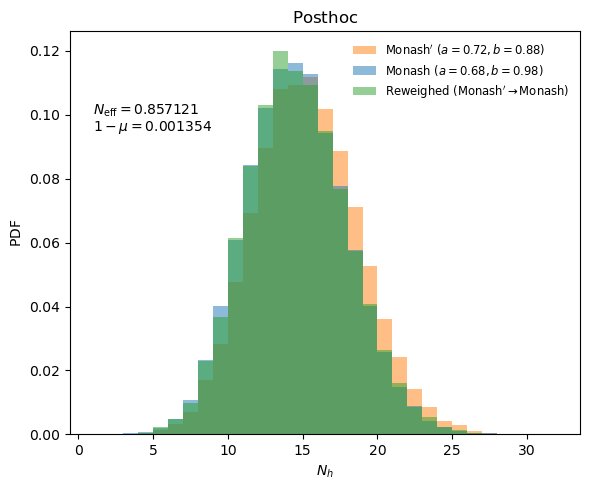

In [36]:
# Histrogram hadron multiplicity
fig, ax = plt.subplots(1,1,figsize=(6,5))

counts, bins, _ = ax.hist(mult_monash_prime[0:nevents], bins = bins, alpha = 0.5, label = r"$\mathrm{Monash'}$ $(a = 0.72, b = 0.88)$", color = 'tab:orange', density = True)
ax.hist(mult_monash[0:nevents], bins = bins, alpha = 0.5, label = r'$\mathrm{Monash}$ $(a = 0.68, b = 0.98)$', color = 'tab:blue', density = True)
ax.hist(pgun_mult_monash_prime_torch.detach().numpy(), bins = bins, weights = weights.detach().numpy(), alpha = 0.5, label = r"$\mathrm{Reweighed}$ $(\mathrm{Monash}' \rightarrow \mathrm{Monash})$", color = 'tab:green', density = True)

ax.text(1.0, 0.10, rf'$N_{{\mathrm{{eff}}}} = {Neff:3f}$', fontsize = 10)
ax.text(1.0, 0.095, rf'$1 - \mu = {one_minus_mu:3f}$', fontsize = 10)

ax.set_xlabel(r'$N_h$')
ax.set_ylabel(r'$\mathrm{PDF}$')
ax.legend(frameon = False, fontsize = 'small')
ax.set_title(r'$\mathrm{Posthoc}$')
fig.tight_layout()
fig.savefig('posthoc_reweighting.pdf', format = 'pdf', bbox_inches = 'tight', dpi = 300)
fig.savefig('posthos_reweighting.png', format = 'png', bbox_inches = 'tight', dpi = 300)

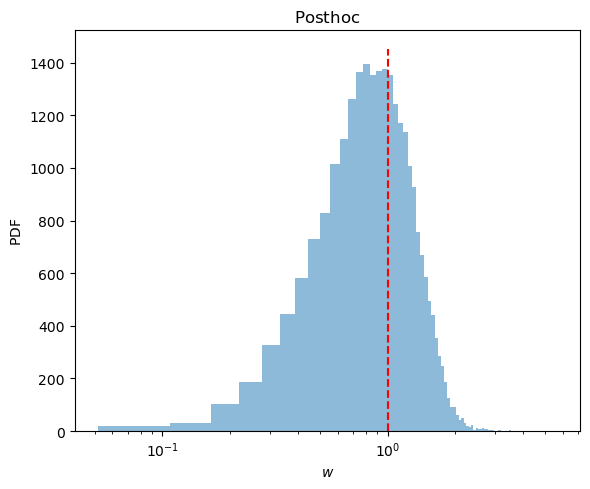

In [39]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.hist(weights.detach().numpy(), 100, alpha = 0.5)
ax.set_xlabel(r'$w$')
ax.set_ylabel(r'$\mathrm{PDF}$')
ax.set_xscale('log')
ax.vlines(1., 0., 1450., color = 'red', linestyle = '--')
ax.set_title(r'$\mathrm{Posthoc}$')
fig.tight_layout()
fig.savefig('posthoc_weights.pdf', format = 'pdf', bbox_inches = 'tight', dpi = 300)
fig.savefig('posthoc_weights.png', format = 'png', bbox_inches = 'tight', dpi = 300)

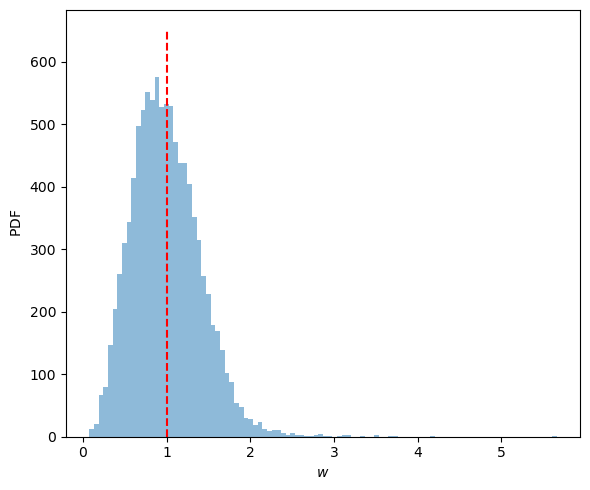

In [28]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.hist(weights.detach().numpy(), 100, alpha = 0.5)
ax.set_xlabel(r'$w$')
ax.set_ylabel(r'$\mathrm{PDF}$')
#ax.set_xscale('log')
ax.vlines(1., 0., 650., color = 'red', linestyle = '--')
fig.tight_layout()
#fig.savefig('posthoc_weights.pdf', format = 'pdf', bbox_inches = 'tight', dpi = 300)
#fig.savefig('posthoc_weights.png', format = 'png', bbox_inches = 'tight', dpi = 300)

In [15]:
# Check the likelihood values against Pythia
z = torch.linspace(0.0, 1.0, 101)
mT = torch.tensor(1.0)
a_monash_prime = torch.tensor(0.72)
b_monash_prime = torch.tensor(0.88)
a_monash = torch.tensor(0.68)
b_monash = torch.tensor(0.98)

#print(reweighter.likelihood(z, mT, a, b))

for zs in z:
    print('z=', zs, ':', reweighter.likelihood(zs, mT, a_monash_prime, b_monash_prime))
# Print the ratios
for zs in z:
    print('z=', zs, "f_monash / f_monash' = ", reweighter.likelihood(zs, mT, a_monash, b_monash) / reweighter.likelihood(zs, mT, a_monash_prime, b_monash_prime))

z= tensor(0.) : tensor(nan, grad_fn=<CopySlices>)
z= tensor(0.0100) : tensor(1.9287e-22, grad_fn=<CopySlices>)
z= tensor(0.0200) : tensor(1.8351e-17, grad_fn=<CopySlices>)
z= tensor(0.0300) : tensor(2.8445e-11, grad_fn=<CopySlices>)
z= tensor(0.0400) : tensor(3.2408e-08, grad_fn=<CopySlices>)
z= tensor(0.0500) : tensor(2.0959e-06, grad_fn=<CopySlices>)
z= tensor(0.0600) : tensor(3.2569e-05, grad_fn=<CopySlices>)
z= tensor(0.0700) : tensor(0.0002, grad_fn=<CopySlices>)
z= tensor(0.0800) : tensor(0.0009, grad_fn=<CopySlices>)
z= tensor(0.0900) : tensor(0.0028, grad_fn=<CopySlices>)
z= tensor(0.1000) : tensor(0.0067, grad_fn=<CopySlices>)
z= tensor(0.1100) : tensor(0.0134, grad_fn=<CopySlices>)
z= tensor(0.1200) : tensor(0.0238, grad_fn=<CopySlices>)
z= tensor(0.1300) : tensor(0.0383, grad_fn=<CopySlices>)
z= tensor(0.1400) : tensor(0.0571, grad_fn=<CopySlices>)
z= tensor(0.1500) : tensor(0.0804, grad_fn=<CopySlices>)
z= tensor(0.1600) : tensor(0.1078, grad_fn=<CopySlices>)
z= tensor(0.17

### Data structure

In [15]:
# Accept-reject dataset
print('Single event-level accepted and rejected z-value array:')
print(pgun_accept_reject_monash[0]) # Event (zero-padded to a fixed length of 50)
print()
print('Accepted and rejected z-values for first hadron:')
print(pgun_accept_reject_monash[0,0]) # Accepted and rejected z-values for first hadron
print()
print('First hadron accepted z-value:')
print(pgun_accept_reject_monash[0,0,0]) # Accepted z-value
print()
print('First hadron rejected z-values (zero-padded to a fixed length of 99):')
print(pgun_accept_reject_monash[0,0,1:]) # Rejected z-values (zero-padded to a fixed lenght of 99)
print()
# Hadron dataset
print('Event-level hadron data array:')
print(pgun_hadrons_monash[0]) # Event (zero-padded to a fixed length of 50)
print()
print('(p_x, p_y, p_z, E, m_h) of first hadron:')
print(pgun_hadrons_monash[0,0]) # First hadron (p_x, p_y, p_z, E, m_h)

Event-level accepted and rejected z-value array:
[[0.0686964 0.874901  0.920626  ... 0.        0.        0.       ]
 [0.395404  0.359597  0.32135   ... 0.        0.        0.       ]
 [0.322769  0.742624  0.116491  ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]

Accepted and rejected z-values for first hadron:
[0.0686964 0.874901  0.920626  0.227735  0.254977  0.106352  0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.  